# Transfer Learning with CNNs in Pytorch



These two major transfer learning scenarios look as follows:

-     Finetuning the convnet: Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
-     ConvNet as fixed feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.


In [0]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode


# Load Data

Load Data

We will use torchvision and torch.utils.data packages for loading the data.

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

In [0]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [0]:
!unzip /content/hymenoptera_data.zip

In [0]:
data_transforms = {
    "train" : T.Compose([
                             T.RandomResizedCrop(224),
                             T.RandomHorizontalFlip(),
                             T.ToTensor(),
                             T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
   "val" : T.Compose([
                      T.Resize(256),
                      T.CenterCrop(224),
                      T.ToTensor(),
                      T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
   ]) 
}

In [0]:
data_dir = '/content/hymenoptera_data'

In [0]:
image_datasets = {}
for x in ["train", "val"]:
    image_datasets[x] = datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])

In [0]:
print(image_datasets)

In [0]:
dataloaders = {}
for x in ["train", "val"]:
    dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)

In [0]:
print(dataloaders)

In [0]:
dataset_sizes = {}
for x in ["train", "val"]:
    dataset_sizes[x] = len(image_datasets[x])

In [15]:
print(dataset_sizes)

{'train': 244, 'val': 153}


In [0]:
class_names = image_datasets['train'].classes

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

 # View a Few Images

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


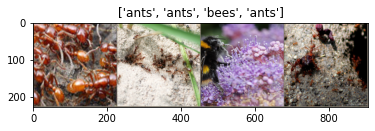

In [20]:
# Get some data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model function

Now, let’s write a general function to train a model. Here, we will illustrate:

    Scheduling the learning rate
    Saving the best model



In [0]:
from copy import deepcopy

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    start = time.time()

    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch {} / {}".format(epoch, num_epochs-1))
        print('-'*20)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            running_loss = 0
            running_corrects = 0
        
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                    
                
                running_loss += loss
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == "train":
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())
            
        print()
    
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


# Visualizing the model predictions

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetuning the convnet

Load a pretrained model and reset final fully connected layer.

In [0]:
model_ft = models.resnet18(pretrained=True)

In [0]:
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names))

In [0]:
model_ft.fc = nn.Linear(num_ftrs, 2)

In [0]:
model_ft = model_ft.to(device)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [0]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train Fine Tuned Network

In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

# ConvNet as fixed feature extractor



Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here.

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

In [0]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

In [0]:
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [52]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0 / 24
--------------------
train Loss: 0.1824 Acc: 0.6393
val Loss: 0.0740 Acc: 0.8824

Epoch 1 / 24
--------------------
train Loss: 0.1365 Acc: 0.7459
val Loss: 0.0427 Acc: 0.9477

Epoch 2 / 24
--------------------
train Loss: 0.1378 Acc: 0.7828
val Loss: 0.0393 Acc: 0.9477

Epoch 3 / 24
--------------------
train Loss: 0.1091 Acc: 0.8238
val Loss: 0.0552 Acc: 0.9346

Epoch 4 / 24
--------------------
train Loss: 0.1118 Acc: 0.7787
val Loss: 0.0612 Acc: 0.9346

Epoch 5 / 24
--------------------
train Loss: 0.1454 Acc: 0.7664
val Loss: 0.0484 Acc: 0.9477

Epoch 6 / 24
--------------------
train Loss: 0.1767 Acc: 0.7787
val Loss: 0.0488 Acc: 0.9412

Epoch 7 / 24
--------------------
train Loss: 0.0916 Acc: 0.8402
val Loss: 0.0427 Acc: 0.9477

Epoch 8 / 24
--------------------
train Loss: 0.0930 Acc: 0.8484
val Loss: 0.0406 Acc: 0.9477

Epoch 9 / 24
--------------------
train Loss: 0.0780 Acc: 0.8566
val Loss: 0.0419 Acc: 0.9477

Epoch 10 / 24
--------------------
train Loss: 0.1

In [0]:
visualize_model(model_conv)

plt.ioff()
plt.show()